# Loading, evaluating, and visualizing runs

## Visualization imports

In [70]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import pybullet as p
import matplotlib.pyplot as plt
from IPython.display import Video

from rrc.env import cube_env, initializers
from scipy.spatial.transform import Rotation
import numpy as np

import shelve
import pickle
from simple_pid import PID

In [71]:
!ls ../scripts/output

custom_data.bak  hold		   pid-hold	    pid-hold-ki.1  test
custom_data.dat  left		   pid-hold-ki.025  pid-hold-ki.2
custom_data.dir  lift		   pid-hold-ki.05   random
goal.json	 observations.pkl  pid-hold-ki.08   reward.pkl


In [ ]:
output_dir = '../scripts/output'

In [72]:
def rotate_obs_force(obs_force, tip_dir):
    forces = []
    for f, td in zip(obs_force, tip_dir):
        v, w = td
        u = np.cross(v, w)
        R = np.vstack([u, v, w]).T
        forces.append(Rotation.from_matrix(R).inv().as_matrix() @ f)
    return forces

In [73]:
def plot_des_obs_forces(force_df):
    color = ['b', 'orange', 'g'] + ['cyan', 'red', 'olive']
    style = ['-']*3 + ['--']*3
    f, ax = plt.subplots(1,3,figsize=(16,4))
    force_df[::10].plot(y=[col for col in force_df.columns if 'f0' in col], 
                  ax=ax[0], title='Finger 0 tip forces', legend=False, style=style, color=color)
    force_df[::10].plot(y=[col for col in force_df.columns if 'f1-' in col],
                  ax=ax[1], title='Finger 1 tip forces', legend=False, style=style, color=color)
    lines = force_df[::10].plot(y=[col for col in force_df.columns if 'f2-' in col], 
                          ax=ax[2], title='Finger 2 tip forces', legend=False, style=style, color=color)
    line_labels = ['des normal', 'des latfric1', 'des latfric2', 'obs normal', 'obs latfric1', 'obs latfric2']
    plt.figlegend( lines.lines, line_labels, loc = 'lower center', borderaxespad=0.1, ncol=6, labelspacing=0.,  prop={'size': 13} )

In [74]:
def load_obs_des_forces(output_dir, return_pos=False):
    # Loads observations
    obs = pickle.load(open(f'{output_dir}/observations.pkl', 'rb'))

    # Loads and formats custom logs for observed and desired tip forces
    des_obs_forces = shelve.open(f'{output_dir}/custom_data')
    des_forces, obs_forces = des_obs_forces.get('des_tip_forces'), des_obs_forces.get('obs_tip_forces')
    obs_tip_dir, obs_tip_pos = des_obs_forces.get('obs_tip_dir'), des_obs_forces.get('obs_tip_pos')

    des_forces = [d.get('data') for d in des_forces]
    obs_forces = [d.get('data') for d in obs_forces]
    obs_tip_dir = [d.get('data') for d in obs_tip_dir]
    obs_tip_pos = [d.get('data') for d in obs_tip_pos]
    # obs_forces = [rotate_obs_force(forces, tip_dirs) for forces, tip_dirs in zip(obs_forces, obs_tip_dir)]

    des_labels = [f'des_f{i}-{f}' for i in range(3) for f in ['nf', 'lf1', 'lf2']]
    obs_labels = [f'obs_f{i}-{f}' for i in range(3) for f in ['nf', 'lf1', 'lf2']]
    force_labels = des_labels + obs_labels

    force_data = [np.concatenate((np.asarray(df).flatten(), np.asarray(of).flatten())) 
                  for df, of in zip(des_forces, obs_forces)]
    force_df = pd.DataFrame(columns=force_labels, data=force_data)

    obs = obs[-len(des_forces):]
    if return_pos:
        return obs, force_df, obs_tip_pos
    return obs, force_df

In [75]:
obs, force_df, tip_pos = load_obs_des_forces(output_dir, return_pos=True)

In [59]:
obs[0]['achieved_goal']['position']

array([0.02764955, 0.01316102, 0.03348696])

In [61]:
[obs[0]['achieved_goal']['position'] + x[0] for x in tip_pos[1]]

[array([0.02701268, 0.04706483, 0.07214552]),
 array([ 0.03804816, -0.0175176 ,  0.07080235]),
 array([-0.0043497 ,  0.00620192,  0.07161877])]

In [35]:
output_dir = '../scripts/output/pid-hold'
_, force_df_pid_hold = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/pid-hold-ki.025'
_, force_df_pid_hold_ki025 = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/pid-hold-ki.05'
_, force_df_pid_hold_ki05 = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/pid-hold-ki.08'
_, force_df_pid_hold_ki08 = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/pid-hold-ki.1'
_, force_df_pid_hold_ki1 = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/pid-hold-ki.2'
_, force_df_pid_hold_ki2 = load_obs_des_forces(output_dir)

output_dir = '../scripts/output/hold'
_, force_df_hold = load_obs_des_forces(output_dir)

In [64]:
output_dir = '../scripts/output'
_, force_df_hold_recent = load_obs_des_forces(output_dir)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.1')

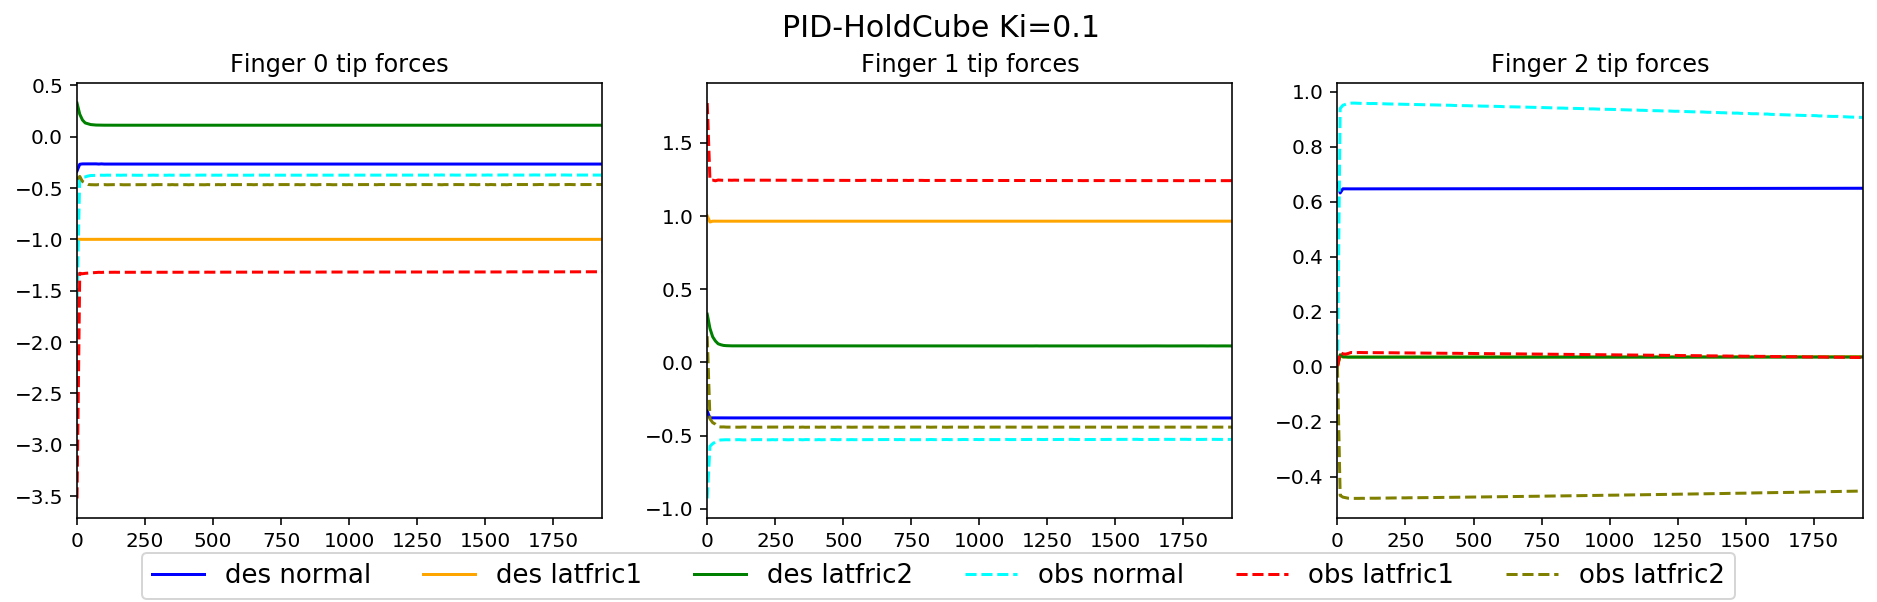

In [69]:
plot_des_obs_forces(force_df_hold_recent)
plt.suptitle('PID-HoldCube Ki=0.1', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.025')

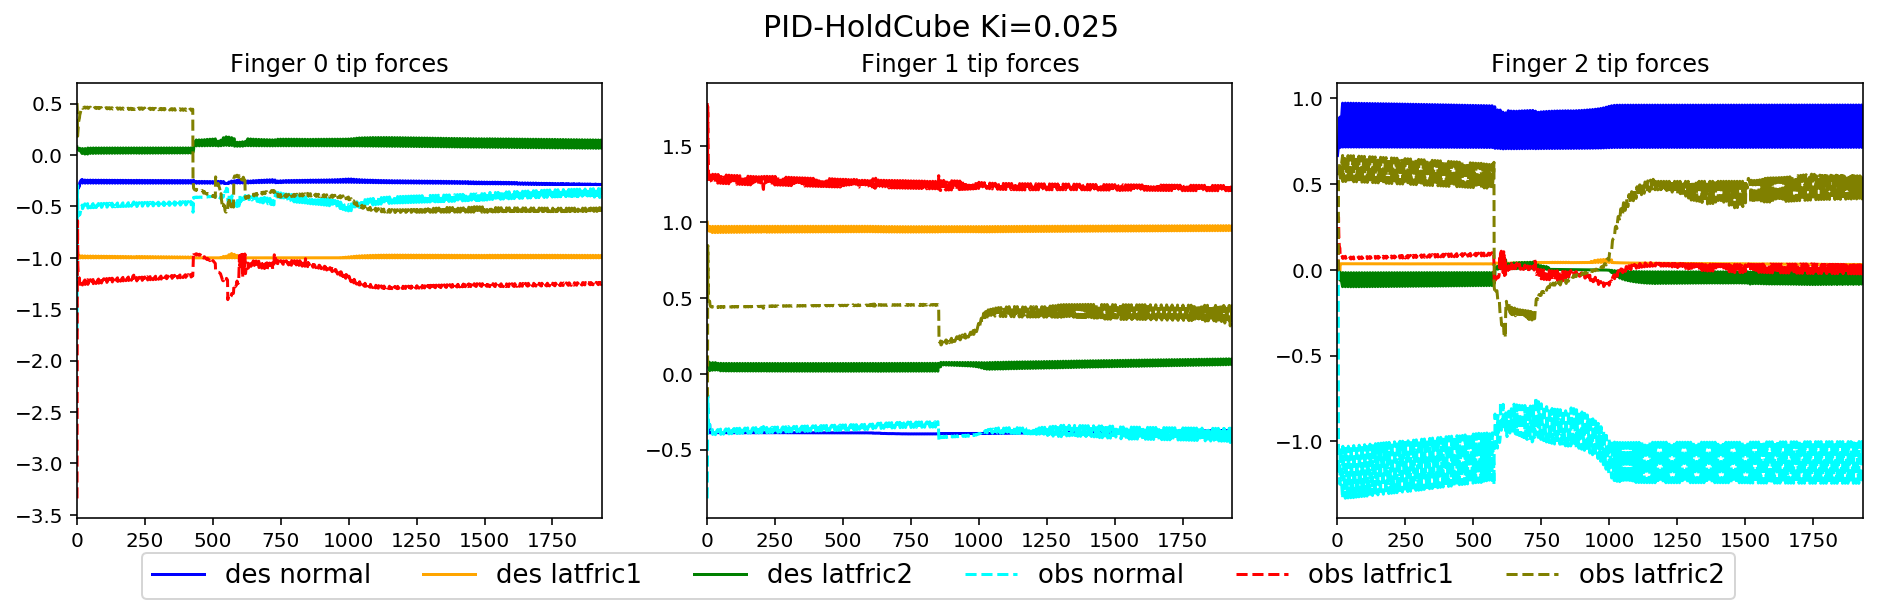

In [63]:
plot_des_obs_forces(force_df_pid_hold_ki025)
plt.suptitle('PID-HoldCube Ki=0.025', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.05')

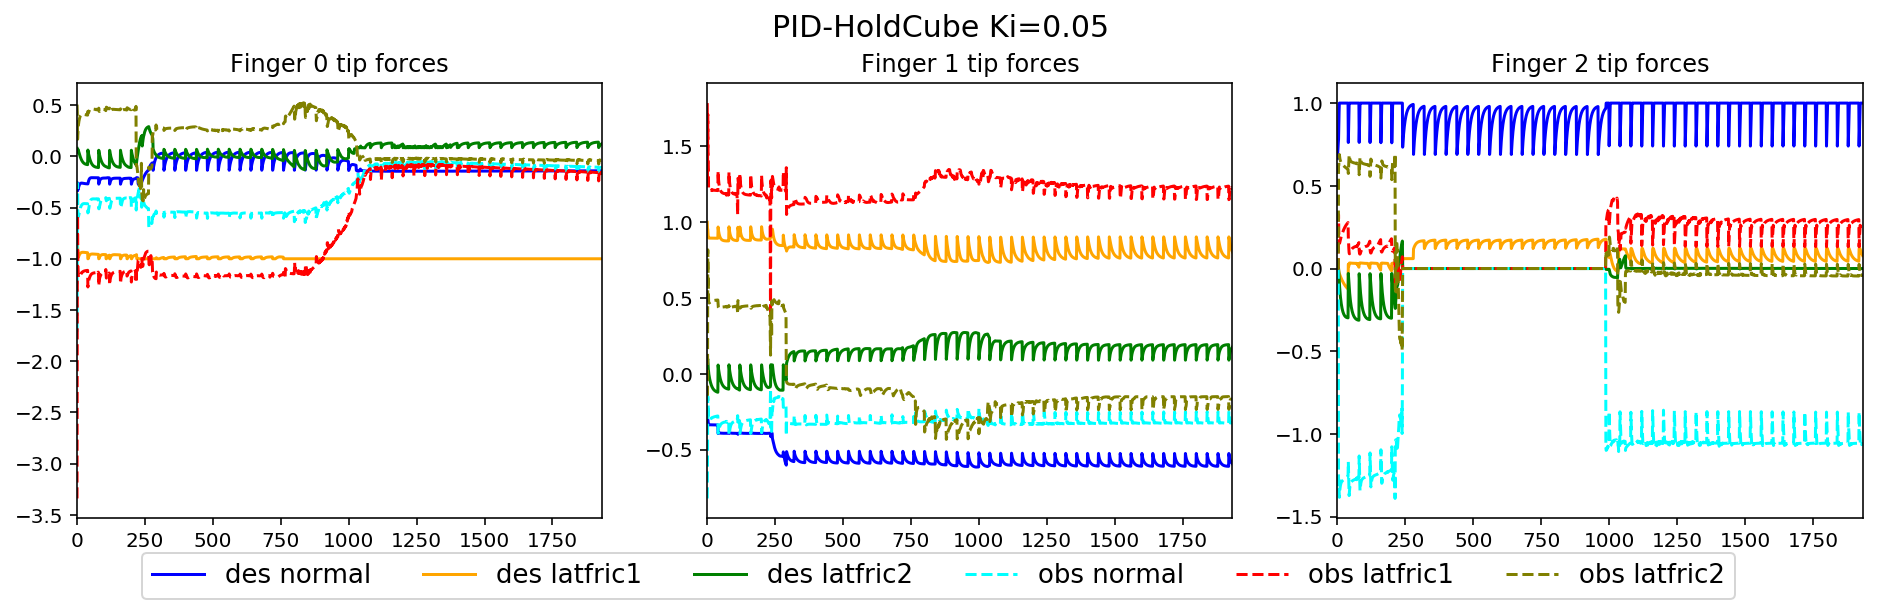

In [24]:
plot_des_obs_forces(force_df_pid_hold_ki05)
plt.suptitle('PID-HoldCube Ki=0.05', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.08')

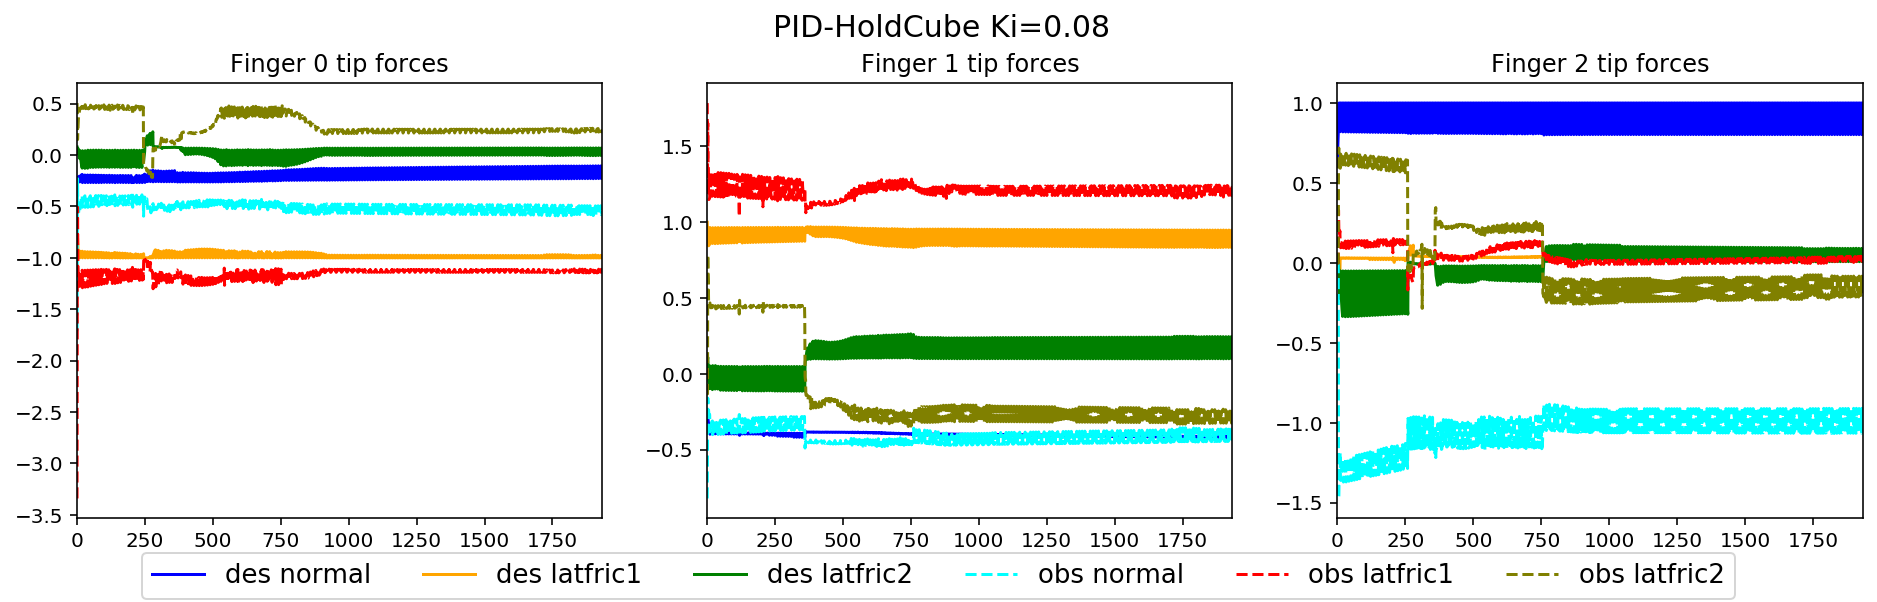

In [38]:
plot_des_obs_forces(force_df_pid_hold_ki08)
plt.suptitle('PID-HoldCube Ki=0.08', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.1')

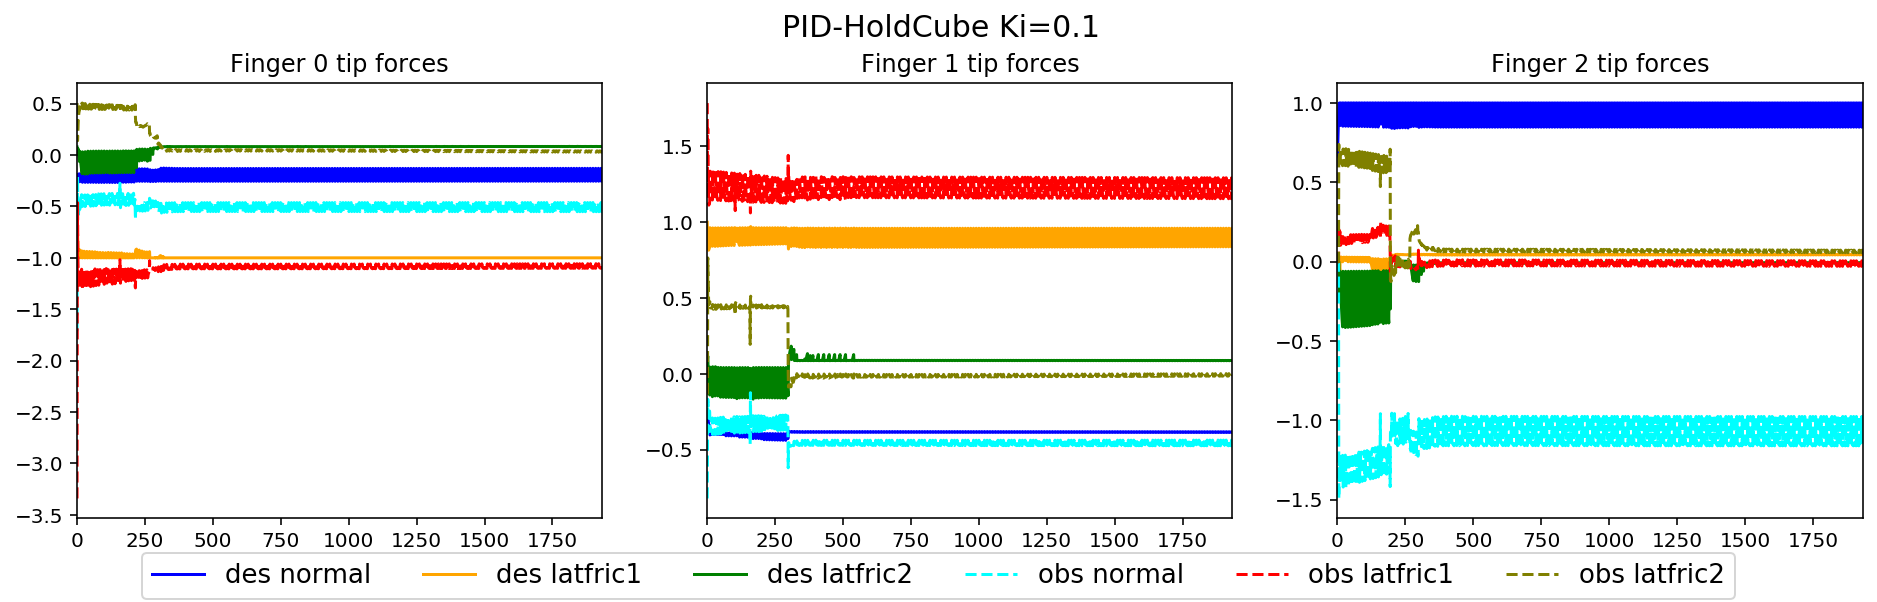

In [34]:
plot_des_obs_forces(force_df_pid_hold_ki1)
plt.suptitle('PID-HoldCube Ki=0.1', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube Ki=0.2')

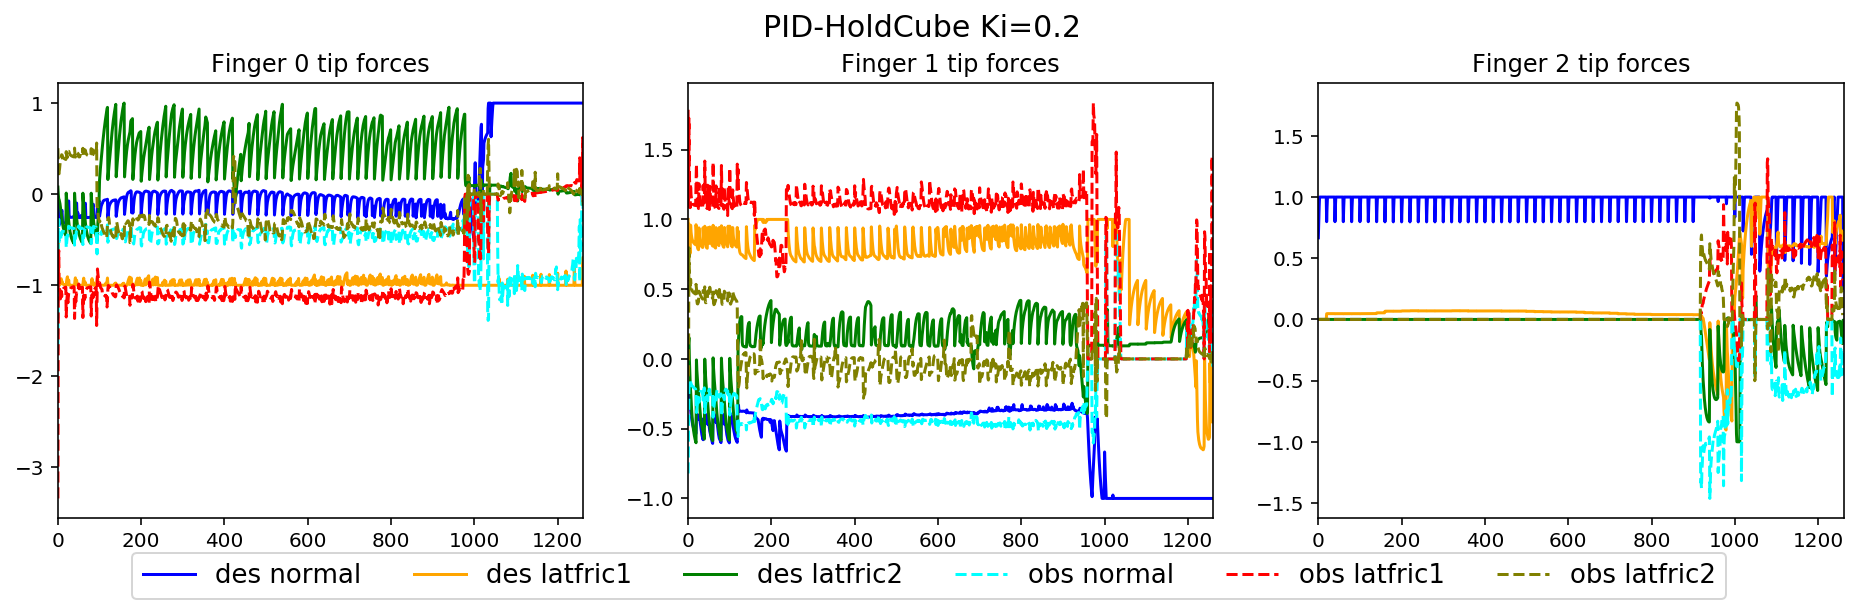

In [27]:
plot_des_obs_forces(force_df_pid_hold_ki2)
plt.suptitle('PID-HoldCube Ki=0.2', y=1., fontsize=15)

Text(0.5, 1.0, 'PID-HoldCube')

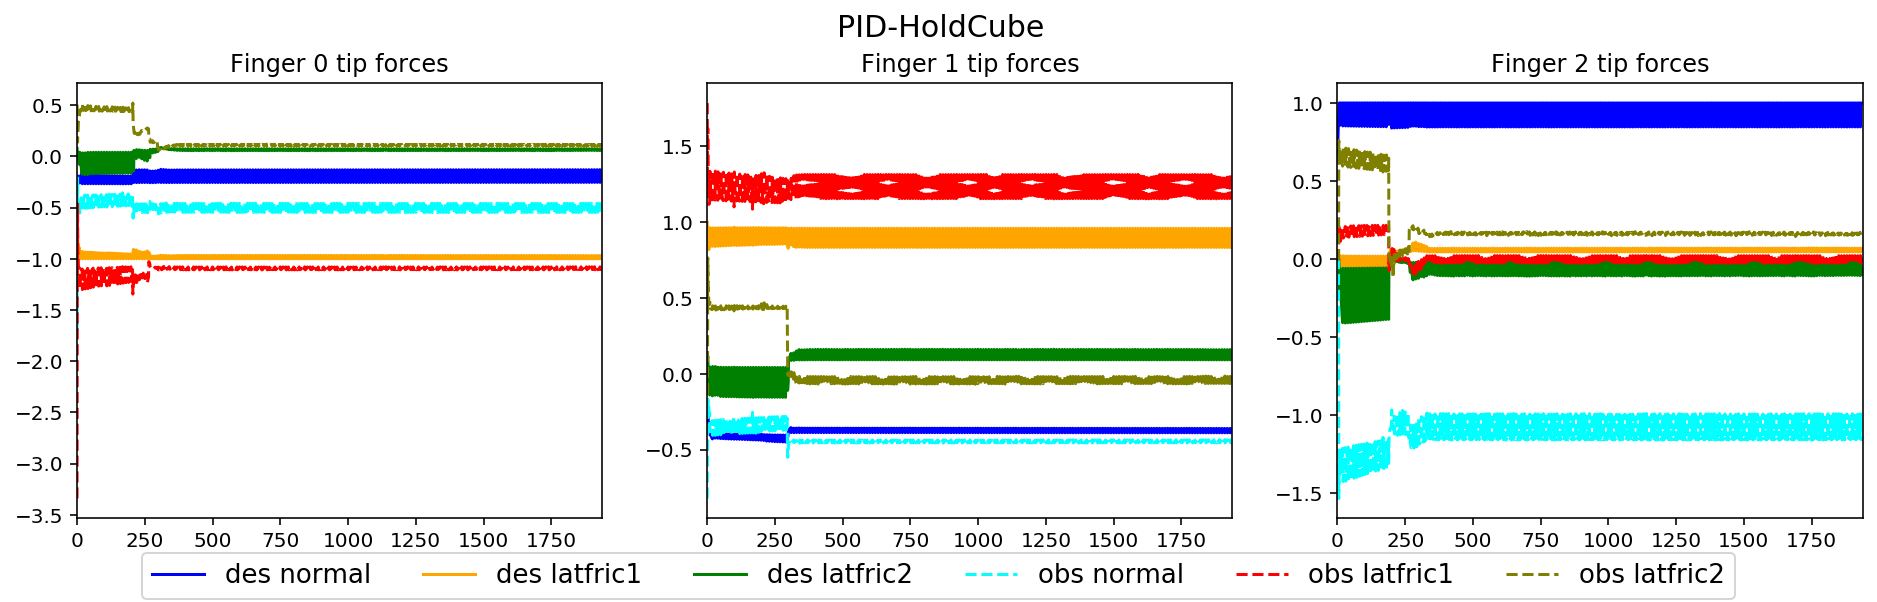

In [14]:
plot_des_obs_forces(force_df_pid_hold)
plt.suptitle('PID-HoldCube', y=1., fontsize=15)

Text(0.5, 1.0, 'HoldCube')

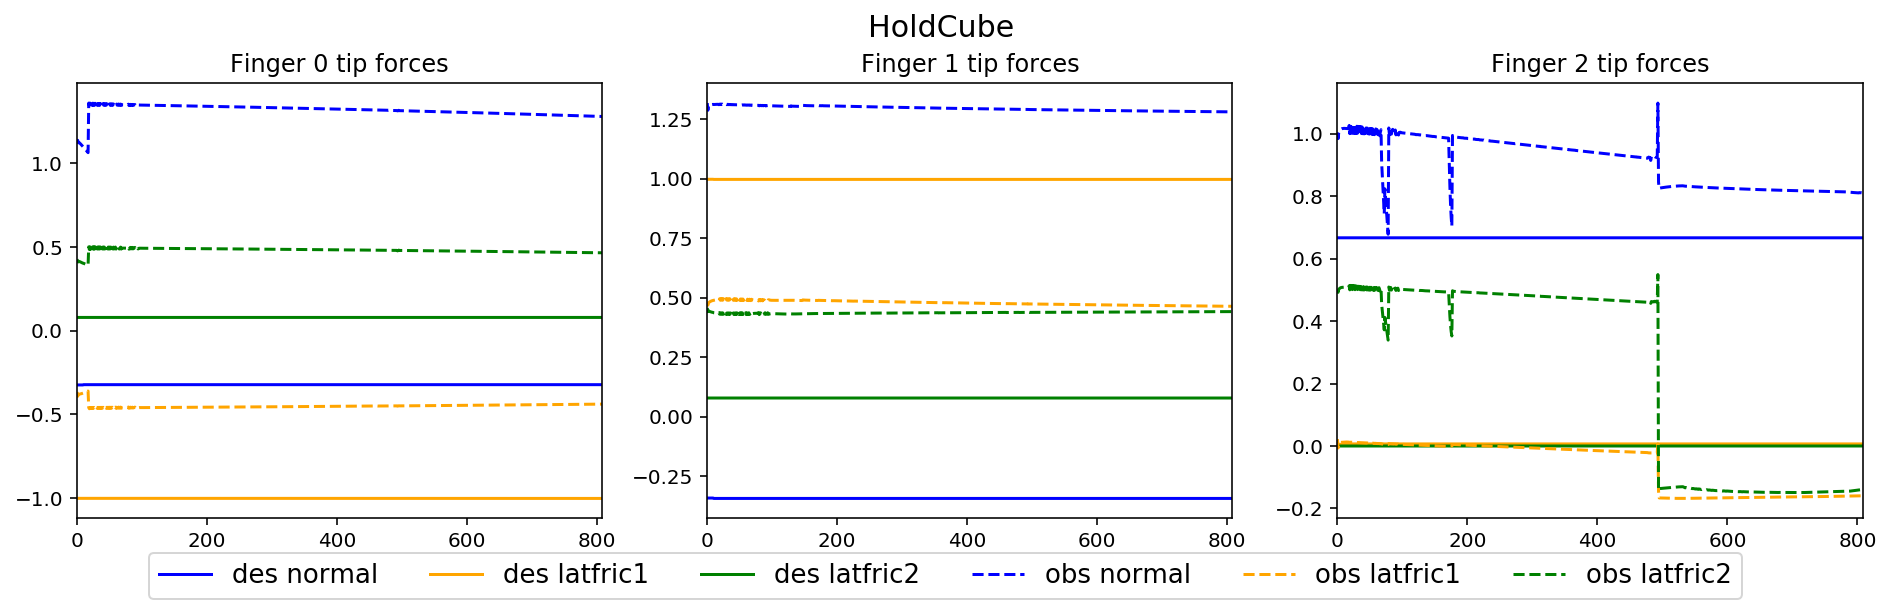

In [9]:
plot_des_obs_forces(force_df_hold)
plt.suptitle('HoldCube', y=1., fontsize=15)

In [11]:
q = Rotation.from_euler('xyz', [0,0,90], degrees=True).as_quat()

In [12]:
initializer = initializers.fixed_init(1, default_initial_state=dict(position=np.array([0,0,.0325]), orientation=np.array(q)))
env = cube_env.ContactForceWrenchCubeEnv(None, 1, initializer=initializer, debug=True, use_relaxed=False, cone_approx=True)

In [ ]:
env.reset()
ac = np.array([0.4,0,0,0,0,0])
env.step(ac)

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
DEBUG: Did not solve contact force opt for desired wrench: [0. 0. 0. 0. 0. 0.], contact points: [array([0., 1., 0.]), array([1., 0., 0.]), array([-1.,  0.,  0.])]
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
> /scr-ssd/ksrini/benchmark-rrc/rrc/env/cube_env.py(927)get_balance_contact_forces()
    925                 if self.debug:
    926                     import pdb; pdb.set_trace()
--> 927                 return balance_force
    928 
    929         balance_f = balance_force.detach().numpy()



ipdb>  L = np.array([0,0,0,0,0,0,.4,0,0])
ipdb>  np.round(G @ L, 3)


array([ 0.   ,  0.4  ,  0.   ,  0.   ,  0.   , -0.013])


ipdb>  des_wrench


array([0., 0., 0., 0., 0., 0.])


ipdb>  c


DEBUG: Grasp matrix:
[[ 1.     -0.      0.      0.      1.      0.     -0.     -1.      0.    ]
 [-0.      1.      0.     -1.     -0.      0.      1.      0.      0.    ]
 [-0.     -0.      1.      0.     -0.      1.     -0.      0.      1.    ]
 [-0.     -0.      0.0335  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.      0.     -0.0335 -0.      0.      0.0335]
 [-0.0335  0.     -0.     -0.0335 -0.      0.     -0.0335 -0.     -0.    ]]
> /scr-ssd/ksrini/benchmark-rrc/rrc/env/cube_env.py(910)get_balance_contact_forces()
    908             gymlogger.debug("Grasp matrix:\n{}".format(np.round(G,4)))
    909             import pdb; pdb.set_trace()
--> 910         G_t = torch.from_numpy(G.astype('float32'))
    911 
    912         # External wrench on object from gravity



ipdb>  des_wrench


array([0.4, 0. , 0. , 0. , 0. , 0. ])


ipdb>  G @ L


*** NameError: name 'L' is not defined


ipdb>  L = np.array([0,0,0,0,0,0,.4,0,0])
ipdb>  np.round(G @ L, 3)


array([-0.   ,  0.4  , -0.   ,  0.   , -0.   , -0.013])


## Helper functions

In [10]:
import gym
import torch.nn as nn
from gym import ObservationWrapper
from gym.spaces import flatten_space
from gym.wrappers import FilterObservation
from rrc.env import initializers, cube_env, make_env
from rrc.env.reward_fns import *
from rrc.env.wrappers import MonitorPyBulletWrapper, ResidualPDWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import CombinedExtractor
from stable_baselines3.common.preprocessing import get_flattened_obs_dim, is_image_space
from stable_baselines3 import HerReplayBuffer, SAC, TD3, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


class FlattenGoalObs(ObservationWrapper):
    def __init__(self, env, observation_keys):
        super().__init__(env)
        obs_space = self.env.observation_space
        obs_dict = {k: flatten_space(obs_space[k]) for k in observation_keys}
        self.observation_space = gym.spaces.Dict(obs_dict)

    def observation(self, obs):
        n_obs = {}
        for k in self.observation_space.spaces:
            if isinstance(obs[k], dict):
                obs_list = [obs[k][k2] for k2 in self.env.observation_space[k]]
                n_obs[k] = np.concatenate(obs_list)
            else:
                n_obs[k] = obs[k]
        return n_obs


class HERCombinedExtractor(CombinedExtractor):
    """
    HERCombinedExtractor is a combined extractor which only extracts pre-specified observation_keys to include in
    the observation, while retaining them at the environment level so that they may still be stored in the replay buffer
    """

    def __init__(self, observation_space: gym.spaces.Dict, cnn_output_dim: int = 256, observation_keys: list = []):
        # TODO we do not know features-dim here before going over all the items, so put something there. This is dirty!
        super(CombinedExtractor, self).__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        for key in observation_keys:
            subspace = observation_space.spaces[key]
            # The observation key is a vector, flatten it if needed
            extractors[key] = nn.Flatten()
            total_concat_size += get_flattened_obs_dim(subspace)

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size



def make_model(ep_len, lr, exp_dir=None, env=None, use_goal=True,
               use_sde=False, log_std_init=-3, load_path=None,
               residual=False):
    if use_goal:
        obs_keys = ['desired_goal', 'achieved_goal', 'observation']
    else:
        obs_keys = ['observation']

    policy_kwargs = dict(
                    log_std_init=log_std_init,
                    features_extractor_class=HERCombinedExtractor,
                    features_extractor_kwargs=dict(observation_keys=obs_keys))
    if use_sde:
        sde_kwargs = dict(
                use_sde=True,
                use_sde_at_warmup=False,
                sde_sample_freq=64)
    else:
        sde_kwargs = {}

    rb_kwargs = dict(n_sampled_goal=4,
                     goal_selection_strategy='future',
                     online_sampling=False,
                     max_episode_length=ep_len)

    model = SAC('MultiInputPolicy', env,
                # tensorboard_log=exp_dir,
                replay_buffer_class=HerReplayBuffer,
                # Parameters for HER
                replay_buffer_kwargs=rb_kwargs,
                policy_kwargs=policy_kwargs,
                verbose=1, buffer_size=int(1e6),
                learning_starts=20000,
                learning_rate=lr,
                gamma=0.99, batch_size=256, residual=residual, **sde_kwargs)
    if load_path is not None:
        if osp.isdir(load_path):
            load_path = osp.join(load_path, 'best_model.zip')
        model.load(load_path, env)
    return model



def make_ppo_model(ep_len, lr, exp_dir=None, env=None, use_goal=True,
                   use_sde=True, dry_run=False):
    if use_goal:
        obs_keys = ['desired_goal', 'observation']
    else:
        obs_keys = ['observation']

    policy_kwargs = dict(
                    log_std_init=-3,
                    features_extractor_class=HERCombinedExtractor,
                    features_extractor_kwargs=dict(observation_keys=obs_keys))
    if use_sde:
        sde_kwargs = dict(
                use_sde=True,
                sde_sample_freq=4)
    else:
        sde_kwargs = {}
    tensorboard_log = exp_dir if dry_run else None
    model = PPO('MlpPolicy', env,
                tensorboard_log=tensorboard_log,
                # Parameters for HER
                policy_kwargs=policy_kwargs,
                verbose=1,
                learning_rate=lr,
                n_steps=1000,
                gamma=0.99, batch_size=250, **sde_kwargs)
    return model



wandb_root = '/scr-ssd/ksrini/spinningup/notebooks' # '/scr-ssd/ksrini/benchmark-rrc/training_scripts' # 
get_save_path = lambda run: '/'.join([wandb_root] + run.config['exp_dir'].split('/')[1:])

def display_video(path=None, run=None):
    if run:
        path = get_save_path(run.config['exp_dir'])
    return Video(path, embed=True, width=640)

## Visualizing a trajectory (mp4 video)

In [4]:
Video('/scr-ssd/ksrini/spinningup/notebooks/videos/sim-22.mp4', embed=True, width=640)

## Loading a wandb run

In [5]:
import os
import wandb
import pandas as pd
import numpy as np
import os.path as osp
from trifinger_simulation.tasks.move_cube import Pose
import json

api = wandb.Api()

In [6]:
def run_history(run_id, proj='cvxrl', keys=None, samples=1000):
    if len(run_id.split('/')) == 2:
        proj, run_id = run_id.split('/')
    if keys:
        data = api.run('krshna/{}/{}'.format(proj, run_id)).history(samples=samples, keys=keys, pandas=False)
        while len(data) == 1:
            data = data[0]
        return pd.DataFrame(data)
    history = api.run('krshna/{}/{}'.format(proj, run_id)).history(samples=samples, keys=keys)
    keep_cols = ([c for c in history.columns if 'train' in c] 
     + [c for c in history.columns if 'episodes' in c]
     + [c for c in history.columns if 'rollout' in c])

    new_df = {}
    for c in keep_cols:
        new_df[c] = history[c][~history[c].isna()].values
    new_df['global_step'] = history['global_step'][~history[c].isna()].values
    return new_df

In [13]:
hist.keys()

dict_keys(['train/actor_loss', 'train/critic_loss', 'train/ent_coef', 'train/ent_coef_loss', 'train/learning_rate', 'train/n_updates', 'time/episodes', 'rollout/ep_len_mean', 'rollout/ep_ori_err_mean', 'rollout/ep_pos_err_mean', 'rollout/ep_rew_mean', 'global_step'])

## PPO Run

In [7]:
run_id = '1tq7w30i'
run = api.run('krshna/cvxrl/{}'.format(run_id))

In [ ]:
env_cls = make_env_cls(diff=run.config['diff'], episode_length=500, reward_fn='train2',
                       initializer='center', torque_factor=1., force_factor=1.)

wrapper = lambda env: FlattenGoalObs(ResidualPDWrapper(env, force_factor=.1, torque_factor=.25), 
                                     observation_keys=['desired_goal', 'achieved_goal', 'observation'])

env = make_vec_env(env_cls, n_envs=10, wrapper_class=wrapper,
        monitor_kwargs=dict(info_keywords=('ori_err', 'pos_err')))

model = make_ppo_model(500, 3e-4, None, env, True)

## SAC Run

In [8]:
run_id = '9sp6xgul'
run = api.run('krshna/cvxrl/{}'.format(run_id))

In [11]:
!ls {get_save_path(run)}

5e+05-steps.zip  best_model.zip  evaluations.npz


In [12]:
def make_vec_env(run):
    if run.config.get('contact'):
        env_cls = cube_env.ContactForceCubeEnv
    else:
        env_cls = run.config.get('env_cls')

    env_fn = make_env.env_fn_generator(diff=run.config['diff'], visualization=True, save_freq=1, initializer=run.config['init'],
                                       reward_fn=run.config['rew_fn'], residual=run.config.get('residual', False), env_cls=env_cls)
    env = DummyVecEnv([env_fn])
    return env

In [13]:
# initializer = initializers.fixed_g_init(4, Pose.from_json(json.load(open('/scr-ssd/ksrini/spinningup/notebooks/goal.json', 'r'))).to_dict())

# Create DummyVecEnv
env = make_vec_env(run)

# Create model
use_goal = not(run.config.get('no_goal'))
use_sde = not(run.config.get('no_sde'))
load_path = None # osp.join(get_save_path(run), '2e+05-steps.zip')
model = make_model(run.config.get('ep_len'), run.config['lr'], use_goal=use_goal, use_sde=use_sde, env=env,
                   load_path=load_path)

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Using cuda device


In [18]:
env.envs[0].goal

{'position': array([0.07944405, 0.02919163, 0.07656224]),
 'orientation': array([0, 0, 0, 1])}

In [27]:
!ls {get_save_path(run)}

4e+05-steps.zip  best_model.zip  evaluations.npz


In [35]:
load_path = osp.join(get_save_path(run), 'best_model.zip')# '4e+05-steps.zip')
model = model.load(load_path, env)

## Evaluating a policy

In [10]:
from stable_baselines3.common.evaluation import evaluate_policy

In [36]:
evaluate_policy(model, env, n_eval_episodes=5)

(486.53987500000005, 164.06791762038918)

In [37]:
env.close()

In [30]:
gym_env = env.envs[0]

o = gym_env.reset()
d = False
rs = []
acs = []

while not d:
    ac, _ = model.predict(o)
    acs.append(ac)
#     ac = gym_env.action_space.sample()
    o,r,d,i = gym_env.step(ac)
    rs.append(r)

In [71]:
model.predict(o, deterministic=True)

(array([-0.06126785,  0.00481224, -0.0344879 ,  0.05529511, -0.01432532,
         0.04956543,  0.01054287, -0.05547428,  0.06105804], dtype=float32),
 None)

In [46]:
!ls {get_save_path(run)}

2e+05-steps.zip  best_model.zip  evaluations.npz


In [50]:
display_video(osp.join(get_save_path(run), 'videos', 'sim-20.mp4'))